This is a Laplace equation on a disk shaped domain with a Dirichlet and a periodic boundary condition, solved with a PINN model using the DeepXDE library.

*In this version, i built my own methods for the calculation of the jacobian and hessian matrices, which also save all computed derivatives and reuse them when needed to save computations.*

<br>
\begin{equation}
r\frac{\partial y}{\partial r} + r^2\frac{\partial y}{\partial r^2} + \frac{\partial y}{\partial θ^2} = 0 \hspace{1cm} r∈[0,1], θ∈[0,2π]
\end{equation}

<br>

\begin{equation}
y(1,θ)=cos(θ)
\end{equation}

<br>

\begin{equation}
y(r,θ+2π)=y(r,θ)
\end{equation}

Test losses after 5000 epochs are approximately:

*In accordance to y output:* **1.18e-06**

*In accordance to initial conditions:* **1.07e-06**

*In accordance to the known solution:* **1.43e-03**

In [1]:
# Import libraries

!pip install deepxde
import deepxde as dde
import numpy as np
from deepxde.backend import tf

     |████████████████████████████████| 122 kB 5.2 MB/s 
     |████████████████████████████████| 100 kB 7.4 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
# Define jacobian method
J = {}

def jacobian(y, x, i = 0, j = 0):

    key = (y.ref(), x.ref())

    if y.shape[1] > 1:
        y = y[:, i : i + 1]

    if key not in J:
        y_index = {}
        y_index[i] = tf.gradients(y, x)[0]
        J[key] = y_index

    if i not in J[key]:
        J[key][i] = tf.gradients(y, x)[0]

    return J[key][i][:, j : j + 1]

In [3]:
# Define hessian method
H = {}

def hessian(y, x, i = 0, j = 0, component = 0):

    key = (y.ref(), x.ref())

    if (key not in J) or (component not in J[key]):
        jacobian(y, x, component, i)

    grad = J[key][component][:, i : i + 1]

    if key not in H:
        y_index = {}
        x_index = {}
        x_index[i] = tf.gradients(grad, x)[0]
        y_index[component] = x_index
        H[key] = y_index

    if component not in H[key]:
        x_index = {}
        x_index[i] =  tf.gradients(grad, x)[0]
        H[key][component] = x_index

    if i not in H[key][component]:
        H[key][component][i] =  tf.gradients(grad, x)[0]

    return H[key][component][i][:, j : j + 1]

In [4]:
# Define computational geometry, differential equation and boundary conditions

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 2 * np.pi])

def pde(x, y):
    dy_rr = hessian(y, x, i = 0, j = 0)
    dy_thetatheta = hessian(y, x, i = 1, j = 1)
    dy_r = jacobian(y, x, i = 0, j = 0)
    return x[:, 0:1] * dy_r + x[:, 0:1] ** 2 * dy_rr + dy_thetatheta


def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)
    

bc_rad = dde.icbc.DirichletBC(geom, lambda x: np.cos(x[:, 1:2]), boundary)

In [5]:
# Make the differential equation model

def solution(x):
    r, theta = x[:, 0:1], x[:, 1:]
    return r * np.cos(theta)

data = dde.data.PDE(geom, pde, bc_rad, num_domain=2540, num_boundary=80, solution=solution)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  total_n_samples))


In [6]:
# Build,compile and train the NN model

net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

def feature_transform(x):
    return tf.concat(
        [x[:, 0:1] * tf.sin(x[:, 1:2]), x[:, 0:1] * tf.cos(x[:, 1:2])], axis=1
    )

net.apply_feature_transform(feature_transform)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=5000)

/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Compiling model...
Building feed-forward neural network...
'build' took 0.096497 s

'compile' took 1.945059 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [4.42e-03, 5.14e-01]    [4.42e-03, 5.14e-01]    [1.01e+00]    
1000      [3.65e-05, 1.54e-05]    [3.65e-05, 1.54e-05]    [4.81e-03]    
2000      [1.09e-05, 5.84e-06]    [1.09e-05, 5.84e-06]    [2.59e-03]    
3000      [4.30e-06, 2.48e-06]    [4.30e-06, 2.48e-06]    [1.68e-03]    
4000      [2.02e-06, 1.38e-06]    [2.02e-06, 1.38e-06]    [1.15e-03]    
5000      [1.18e-06, 1.07e-06]    [1.18e-06, 1.07e-06]    [1.43e-03]    

Best model at step 5000:
  train loss: 2.25e-06
  test loss: 2.25e-06
  test metric: [1.43e-03]

'train' took 71.498925 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


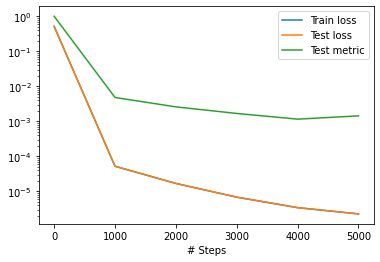

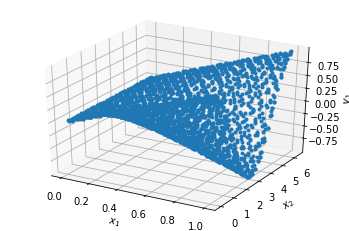

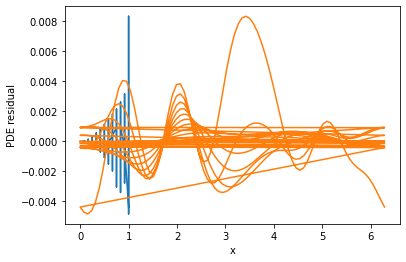

In [7]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Define a random uniform interval of 1000 points to predict.
x = geom.uniform_points(1000, True)

# Make predictions
y = model.predict(x, operator=pde)

# Plot predictions
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()